# CMPE 462 Machine Learning
## Project 1: Feature Engineering


In [1]:
# Imports

import time
import os

import pandas as pd
import numpy as np
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from pandas import DataFrame
import numpy as np
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy.stats import kendalltau

## Read Data
Get points and players sheets

In [2]:
# Reading the data into different dataframes
points_df = pd.read_excel('train_data.xlsx', sheet_name='Points')
players_df = pd.read_excel('train_data.xlsx', sheet_name='Player')

# Adding ranking column to the points table
points_df['Ranking'] = points_df.groupby('Season')['Points'].rank(ascending=False,method='first')

# The Clubs per Season is set as the index to join the dataframes together
# Sorting makes them in the same order to avoid a possible shift
points_group_sc = points_df.set_index(['Season','Club']).sort_index()
players_group_sc = players_df.set_index(['Season','Club']).sort_index()

# Joining the dataframes together as a new dataframe
whole_df = DataFrame(players_group_sc)
whole_df['Points'] = points_group_sc['Points'].copy()
whole_df.head()

Player  Age  Foreign Nationality  Multinational  \
Season Club                                                                     
2007   Ankaragücü             Mateus   24        1      Brazil              0   
       Ankaragücü    Tevfik Altindag   18        0      Turkey              0   
       Ankaragücü  Abdülkadir Kayali   16        0      Turkey              0   
       Ankaragücü       Engin Aktürk   23        0      Turkey              0   
       Ankaragücü  Gökhan Emreciksin   22        0      Turkey              0   

                   Market Value  Points  
Season Club                              
2007   Ankaragücü         25000    43.0  
       Ankaragücü         50000    43.0  
       Ankaragücü        100000    43.0  
       Ankaragücü        100000    43.0  
       Ankaragücü        100000    43.0

In [3]:
# The details of the basic features per
whole_df.describe()

,Age,Foreign,Multinational,Market Value,Points
count,4778.000000,4778.000000,4778.000000,4.778000e+03,4761.000000
mean,25.520301,0.501884,0.278778,1.721085e+06,45.779668
std,4.093131,0.500049,0.448445,2.231122e+06,14.041953
min,14.000000,0.000000,0.000000,2.500000e+04,11.000000
25%,23.000000,0.000000,0.000000,4.500000e+05,37.000000
50%,26.000000,1.000000,0.000000,1.000000e+06,44.000000
75%,28.000000,1.000000,1.000000,2.000000e+06,53.000000
max,38.000000,1.000000,1.000000,3.200000e+07,82.000000


## Understanding the dataset

### First impression
We have 3 types of features:
* Date: 
    - Season
* Player Info:
    - General: Player, Age
    - Origin: Foreign, Nationality, Multinational
    - Price: Market Value
* Club Info:
    - Players
    - Point


## Correlation
Let's start with understanding our dataset can via checking how correlated the features are with respect to each other and output.

### Feature-to-Output Correlation
If we take points as our output, we see that market value is the most correlated feature.
This is not surprising since money buys happiness in post-modern world. Market value seems to be the key in making points predictions.

In [4]:
corr = whole_df.corr()['Points']
# convert series to dataframe so it can be sorted
corr_df = pd.DataFrame(corr)
# correct column label from Points to correlation
corr_df.columns = ["Correlation"]
# sort correlation
corr_sorted = corr_df.sort_values(by=['Correlation'], ascending=False)
corr_sorted.head(15)

,Correlation
Points,1.000000
Market Value,0.423537
Age,0.051654
Multinational,0.045822
Foreign,0.040605


### Feature-to-feature Correlation
Here, feature-to-feature correlation is demonstrated with a heatmap thanks to seaborn library. Since there aren't any highly correlated features, there is no need to consider dropping any at this moment. However, in the end we may consider leveraging either multinational or foreign due to their high correlation.

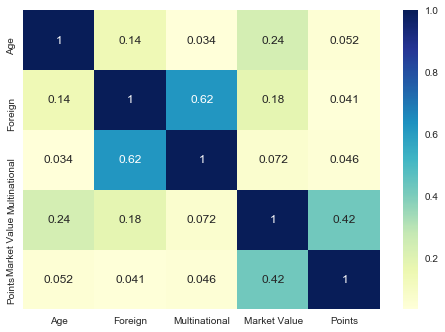

In [5]:
corr = whole_df.corr()
sns.heatmap(corr,cmap="YlGnBu",annot=True)
plt.show()

## Feature Engineering

Here, we're given some direct features about each Club per Season like their points and players' information. These features themselves are not directly useful; instead they should be processed to make them useful. Some intuitive ways of such a process is taking the sum/average/standard deviation of them. Let's dig into dataset for further visualizations and see if we can come up with a better representation.

Some features to analyze:
* Mean/Std age
* Sum Foreign
* Sum Multinational
* Player Count
* Foreign/All
* Sum/Mean/Std market val
* Sum/Mean market value of foreign/local
* Log/exp/sqrt/cbrt of market value
* Market Value mean of the club/ Market Value mean of the season ratio => may give better representation in terms of rankings since 

In [6]:
whole_df['Ranking'] = points_group_sc['Ranking'].copy()
data_means = players_df.groupby(['Season', 'Club']).mean()[['Market Value', 'Age','Foreign','Multinational']]
all_players = players_df.groupby(['Season', 'Club']).count()[['Player']]
data_sums = players_df.groupby(['Season', 'Club']).sum()[['Market Value', 'Age','Foreign','Multinational']]
club_nation_stats = players_df.groupby(['Season', 'Club','Foreign']).mean()[['Market Value','Age']]
data_stds = players_df.groupby(['Season', 'Club']).std()[['Market Value', 'Age']]    
feature_df = pd.DataFrame(data_means)
feature_df['Value Ranking'] = data_means.groupby('Season')['Market Value'].rank(ascending=False,method='first')
feature_df['Points'] = points_group_sc['Points'].copy()
feature_df['Ranking'] = points_group_sc['Ranking'].copy()
feature_df['age_std'] = data_stds['Age'].copy()
feature_df['multi_sum'] = data_sums['Multinational'].copy()
feature_df['foreign_sum'] = data_sums['Foreign'].copy()
feature_df['player_sum'] = all_players['Player'].copy()
feature_df['foreign_ratio'] = (feature_df['foreign_sum'] / feature_df['player_sum']).copy()
feature_df['market_sum'] = data_sums['Market Value'].copy()
feature_df['market_sum_log'] = np.log(data_sums['Market Value']).copy()
feature_df['market_sum_sqrt'] = np.sqrt(data_sums['Market Value']).copy()
feature_df['market_sum_cbrt'] = np.cbrt(data_sums['Market Value']).copy()
feature_df['market_mean_sqrt'] = np.sqrt(data_means['Market Value']).copy()
feature_df['market_mean_cbrt'] = np.cbrt(data_means['Market Value']).copy()
feature_df['market_std'] = data_stds['Market Value'].copy()
club_nation_stats = club_nation_stats.reset_index().set_index(['Season', 'Club'])
feature_df['local_market_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==0,'Market Value']
feature_df['foreign_market_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==1,'Market Value']
feature_df['local_age_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==0,'Age']
feature_df['foreign_age_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==1,'Age']
means = data_means.reset_index()
means_normalized_by_season = means.groupby(['Season']).transform(lambda x: x/x.mean())

#for i in range(len(means_normalized_by_season)):
#    feature_df.loc[i]['market_norm'] = means_normalized_by_season.loc[i]['Market Value']
means_normalized_by_season.head()
feature_df.reset_index(inplace=True)
feature_df['market_norm'] = means_normalized_by_season['Market Value']
feature_df['age_norm'] = means_normalized_by_season['Age']
feature_df = feature_df.set_index(['Season', 'Club'])
feature_df.head()

Market Value        Age   Foreign  Multinational  \
Season Club                                                                
2007   Ankaragücü       9.701613e+05  25.258065  0.419355       0.225806   
       Ankaraspor       1.436207e+06  24.862069  0.517241       0.379310   
       Besiktas         2.344655e+06  24.068966  0.448276       0.275862   
       Bursaspor        9.397059e+05  24.352941  0.411765       0.147059   
       Büyüksehir Bld.  9.965517e+05  25.896552  0.206897       0.034483   

                        Value Ranking  Points  Ranking   age_std  multi_sum  \
Season Club                                                                   
2007   Ankaragücü                13.0    43.0      8.0  4.545824          7   
       Ankaraspor                 5.0    41.0     10.0  3.739023         11   
       Besiktas                   3.0    73.0      3.0  4.970851          8   
       Bursaspor                 14.0    38.0     13.0  4.169749          5   
       Büyüksehir Bld.           12.0    38.0     12.0  4.768534          1   

                        foreign_sum    ...     market_sum_cbrt  \
Season Club                            ...                       
2007   Ankaragücü                13    ...          310.981971   
       Ankaraspor                15    ...          346.634407   
       Besiktas                  13    ...          408.155506   
       Bursaspor                 14    ...          317.314770   
       Büyüksehir Bld.            6    ...          306.878136   

                        market_mean_sqrt  market_mean_cbrt    market_std  \
Season Club                                                                
2007   Ankaragücü             984.967660         98.995316  8.178330e+05   
       Ankaraspor            1198.418498        112.825085  1.149293e+06   
       Besiktas              1531.226689        132.849419  1.785974e+06   
       Bursaspor              969.384280         97.948393  7.595632e+05   
       Büyüksehir Bld.        998.274373         99.884925  1.155262e+06   

                        local_market_mean  foreign_market_mean  \
Season Club                                                      
2007   Ankaragücü            7.083333e+05         1.332692e+06   
       Ankaraspor            1.507143e+06         1.370000e+06   
       Besiktas              2.082812e+06         2.666923e+06   
       Bursaspor             8.475000e+05         1.071429e+06   
       Büyüksehir Bld.       9.673913e+05         1.108333e+06   

                        local_age_mean  foreign_age_mean  market_norm  \
Season Club                                                             
2007   Ankaragücü            24.055556         26.923077     0.716837   
       Ankaraspor            25.285714         24.466667     1.061191   
       Besiktas              23.125000         25.230769     1.732429   
       Bursaspor             23.300000         25.857143     0.694334   
       Büyüksehir Bld.       25.521739         27.333333     0.736337   

                        age_norm  
Season Club                       
2007   Ankaragücü       1.015320  
       Ankaraspor       0.999402  
       Besiktas         0.967521  
       Bursaspor        0.978936  
       Büyüksehir Bld.  1.040986  

[5 rows x 25 columns]

### Age (Mean,Std) - Points Relationship
Let's try to understand how age (and combinations) relate to points. We're using seaborn's lmplot to see the scatter of the data points and univariate regression line. Here, only age_norm parameter seems promising.

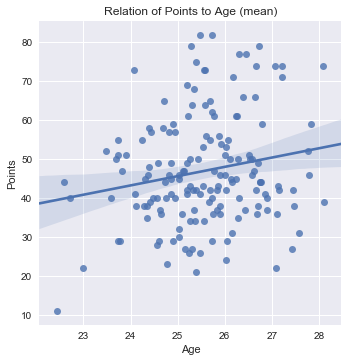

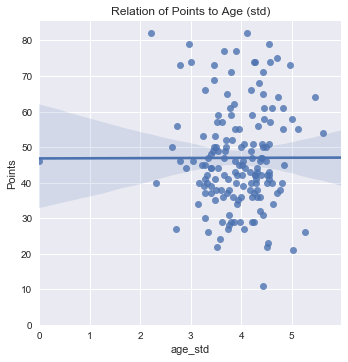

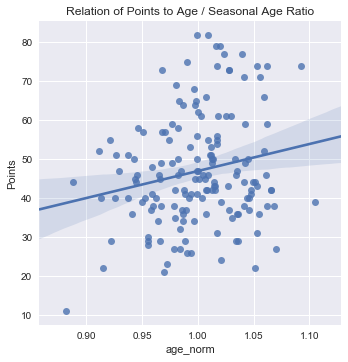

In [7]:
sns.lmplot(x="Age", y="Points", data=feature_df)
plt.title("Relation of Points to Age (mean)")
plt.show()
sns.lmplot(x="age_std", y="Points", data=feature_df)
plt.title("Relation of Points to Age (std)")
plt.xlim(0,)
plt.ylim(0,)
plt.show()
sns.lmplot(x="age_norm", y="Points", data=feature_df)
plt.title("Relation of Points to Age / Seasonal Age Ratio")
plt.show()

### Foreign Ratio - Points Relationship
Again, we don't see a strong relationship among these two.

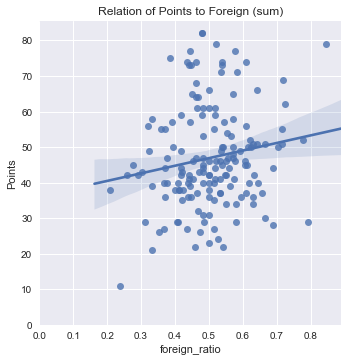

In [8]:
sns.lmplot(x="foreign_ratio", y="Points", data=feature_df)
plt.title("Relation of Points to Foreign (sum)")
plt.xlim(0,)
plt.ylim(0,)
plt.show()

### Multinational (Sum) - Points Relationship
Not much to see.

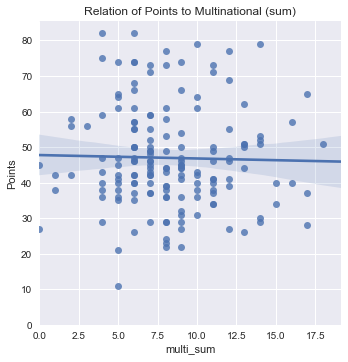

In [9]:
sns.lmplot(x='multi_sum', y='Points', data=feature_df)
plt.title("Relation of Points to Multinational (sum)")
plt.xlim(0,)
plt.ylim(0,)
plt.show()

### Market Value (Sum, Mean, Std, log) - Points Relationship
Now, it's time to analyze our most promising feature, Market Value. There's a stronger relation and we seem to have a linearish relationship for market mean/sum/seasonal ratio over 0.6e8. Another point is that using mean or mean/seasonal mean ratio doesn't make much difference as expected.

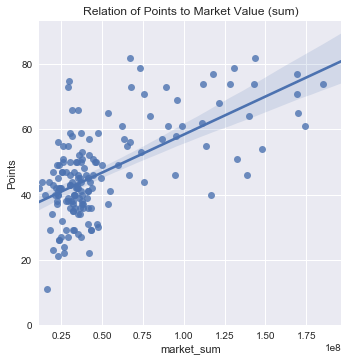

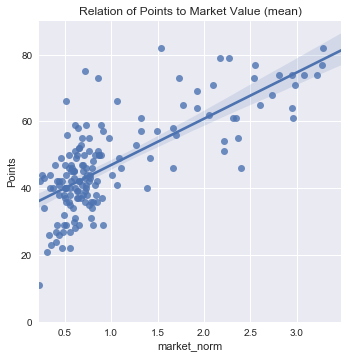

In [10]:
sns.lmplot(x='market_sum', y='Points', data=feature_df)
plt.title("Relation of Points to Market Value (sum)")
plt.xlim(np.min(feature_df['market_sum']),)
plt.ylim(0,)
plt.show()
sns.lmplot(x='market_norm', y='Points', data=feature_df)
plt.title("Relation of Points to Market Value (mean)")
plt.xlim(np.min(feature_df['market_norm']),)
plt.ylim(0,)
plt.show()

However, the scatter points seem to be distributed with a different regime for various market value regions. Let's reveal if the relationship changes among other regions. And as the plots below demonstrate, we may try to come up with a categorization dividing the data into two parts with the help of one-hot encoding.

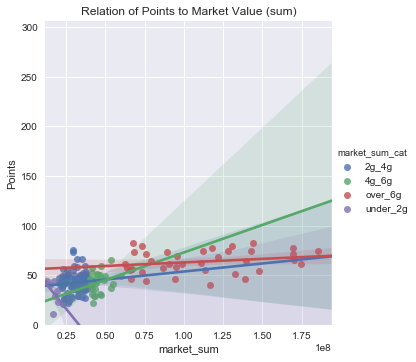

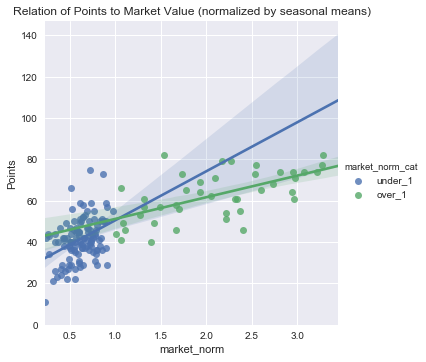

In [11]:
feature_df.loc[feature_df['market_sum'] > 0.6e8, 'market_sum_cat'] = 'over_6g'
feature_df.loc[feature_df['market_sum'] < 0.6e8, 'market_sum_cat'] = '4g_6g'
feature_df.loc[feature_df['market_sum'] < 0.4e8, 'market_sum_cat'] = '2g_4g'
feature_df.loc[feature_df['market_sum'] < 0.2e8, 'market_sum_cat'] = 'under_2g'
sns.lmplot(x='market_sum', y='Points', hue='market_sum_cat', data=feature_df)
plt.title("Relation of Points to Market Value (sum)")
plt.xlim(np.min(feature_df['market_sum']),)
plt.ylim(0,)
plt.show()
feature_df.loc[feature_df['market_norm'] >= 1, 'market_norm_cat'] = 'over_1'
feature_df.loc[feature_df['market_norm'] < 1, 'market_norm_cat'] = 'under_1'
sns.lmplot(x='market_norm', y='Points', hue='market_norm_cat', data=feature_df)
plt.title("Relation of Points to Market Value (normalized by seasonal means)")
plt.xlim(np.min(feature_df['market_norm']),)
plt.ylim(0,)
plt.show()

### Points-Ranking Relationship
The assignment objective is to predict the rankings. We chose to come up with points predictions and rank the teams among each other. Therefore, we're curious if points directly translate to high ranking. However, points-ranking relationship seems trustable enough and it looks like we go on with points predictions

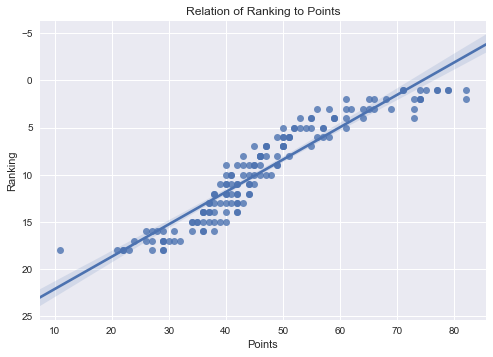

In [12]:
ax = sns.regplot(x='Points', y='Ranking', data=feature_df)
ax.invert_yaxis()
plt.title("Relation of Ranking to Points")
plt.show()

### Seasonal Distributions
Should we take seasonal differences into account? Maybe these visualizations can lead the way to a better representation of seasonal market value/points changes. These plots actually make us think about dropping some disconnected data points (outliers maybe) up above and down below because there seems to be clustered groups in the middle which may better generalize how teams obtain points over a season. This may be considered in future work.

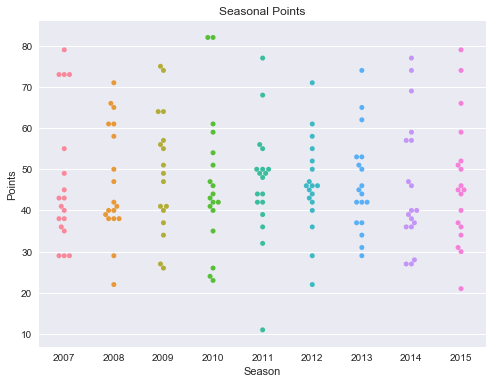

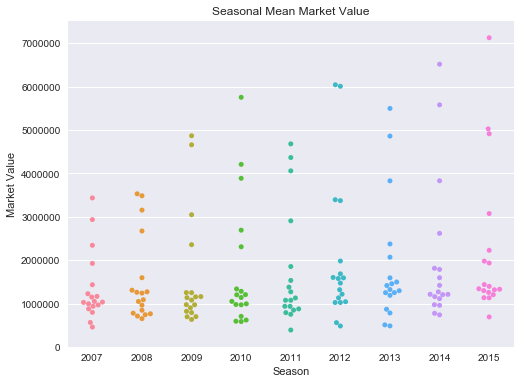

In [13]:
feature_no_index_0 = feature_df.reset_index()
plt.figure(figsize = (8, 6))
sns.swarmplot(x='Season',y='Points',data=feature_no_index_0)
plt.title('Seasonal Points')
plt.figure(figsize=(50, 16))
plt.show()

plt.figure(figsize = (8, 6))
sns.swarmplot(x='Season',y='Market Value',data=feature_no_index_0)
plt.title('Seasonal Mean Market Value')
plt.figure(figsize=(50, 16))
plt.show()

### Understanding Target Variable
Let's check out how points are distributed.

C:\Users\rizao\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\rizao\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


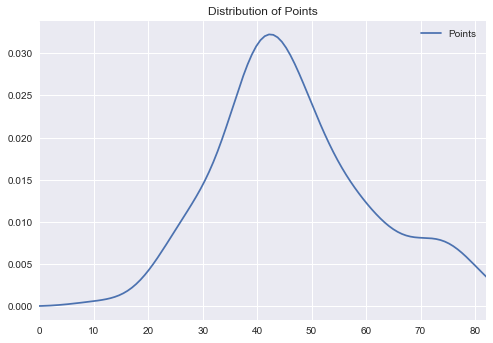

In [14]:
sns.kdeplot(feature_no_index_0['Points']);
plt.title("Distribution of Points")
plt.xlim(0,np.max(feature_no_index_0['Points']))
plt.show()

### Total Market Value by Season

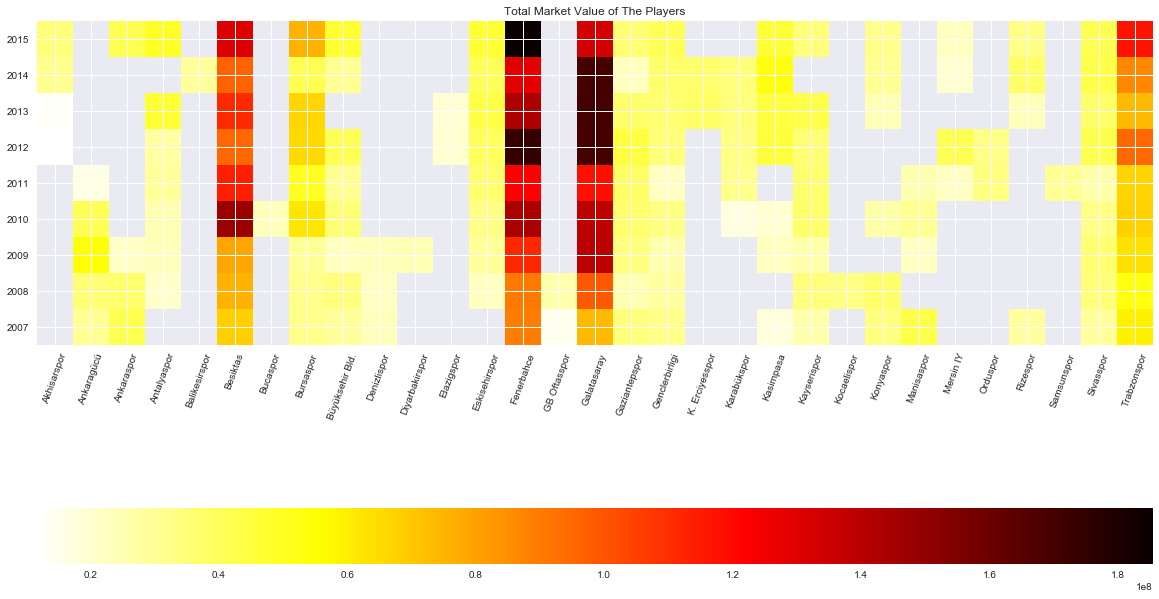

In [15]:
seasons = points_df.Season.unique()
total_market_values_seasons=players_df.groupby(["Season","Club"]).sum().unstack()["Market Value"]
clubs=players_df.Club.unique()

fig=plt.figure(111,figsize=(20,20))

plt.imshow(total_market_values_seasons,  cmap="hot_r", interpolation='nearest', origin='lower')
plt.colorbar(orientation='horizontal')
plt.xticks(range(len(total_market_values_seasons.columns)),total_market_values_seasons.columns,rotation=70)
plt.yticks(range(len(seasons)),seasons)
#plt.gca().set_xticks()
plt.title("Total Market Value of The Players")
plt.show()

### Club - Points Relationship
Club name may represent some other info such as a club's management quality, resources, bureaucratic power, etc. Therefore, we may come up with some features representing these relationships. We have tried to add club names with the help of one-hot encoding, but it didn't provide any improvement.

C:\Users\rizao\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


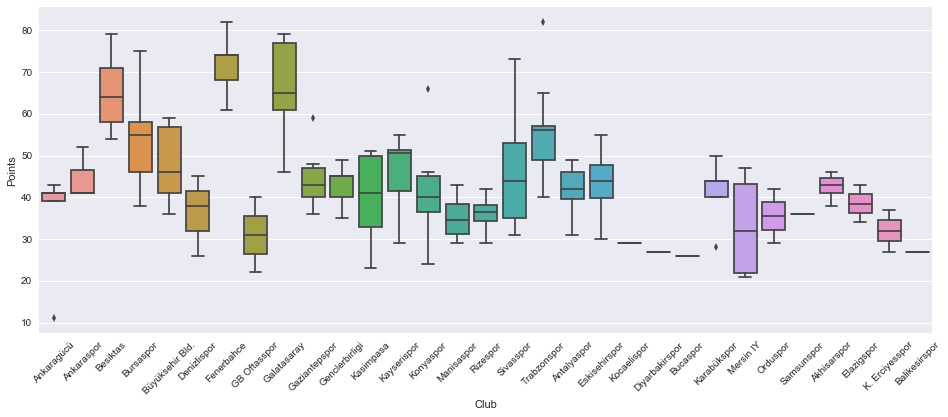

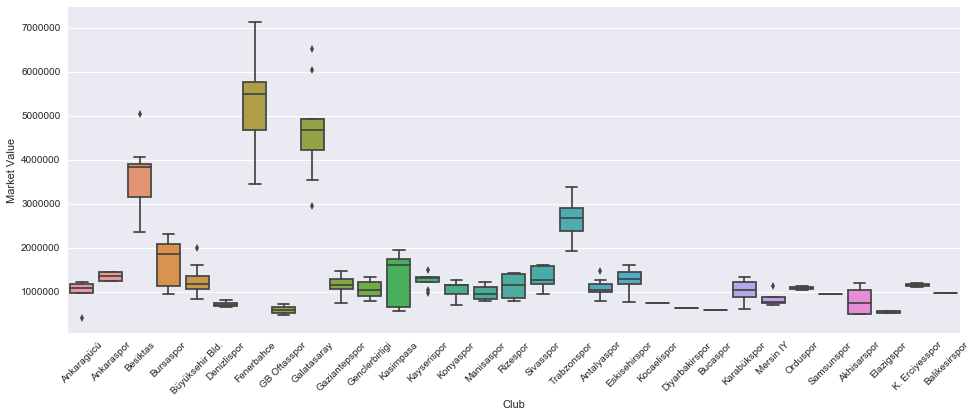

In [16]:
feature_no_index_1 = feature_df.reset_index()
plt.figure(figsize = (16, 6))
sns.boxplot(x = 'Club', y = 'Points',  data = feature_no_index_1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize = (16, 6))
ax = sns.boxplot(x = 'Club', y = 'Market Value',  data = feature_no_index_1)
# ax.invert_yaxis()
plt.xticks(rotation=45)
plt.show()

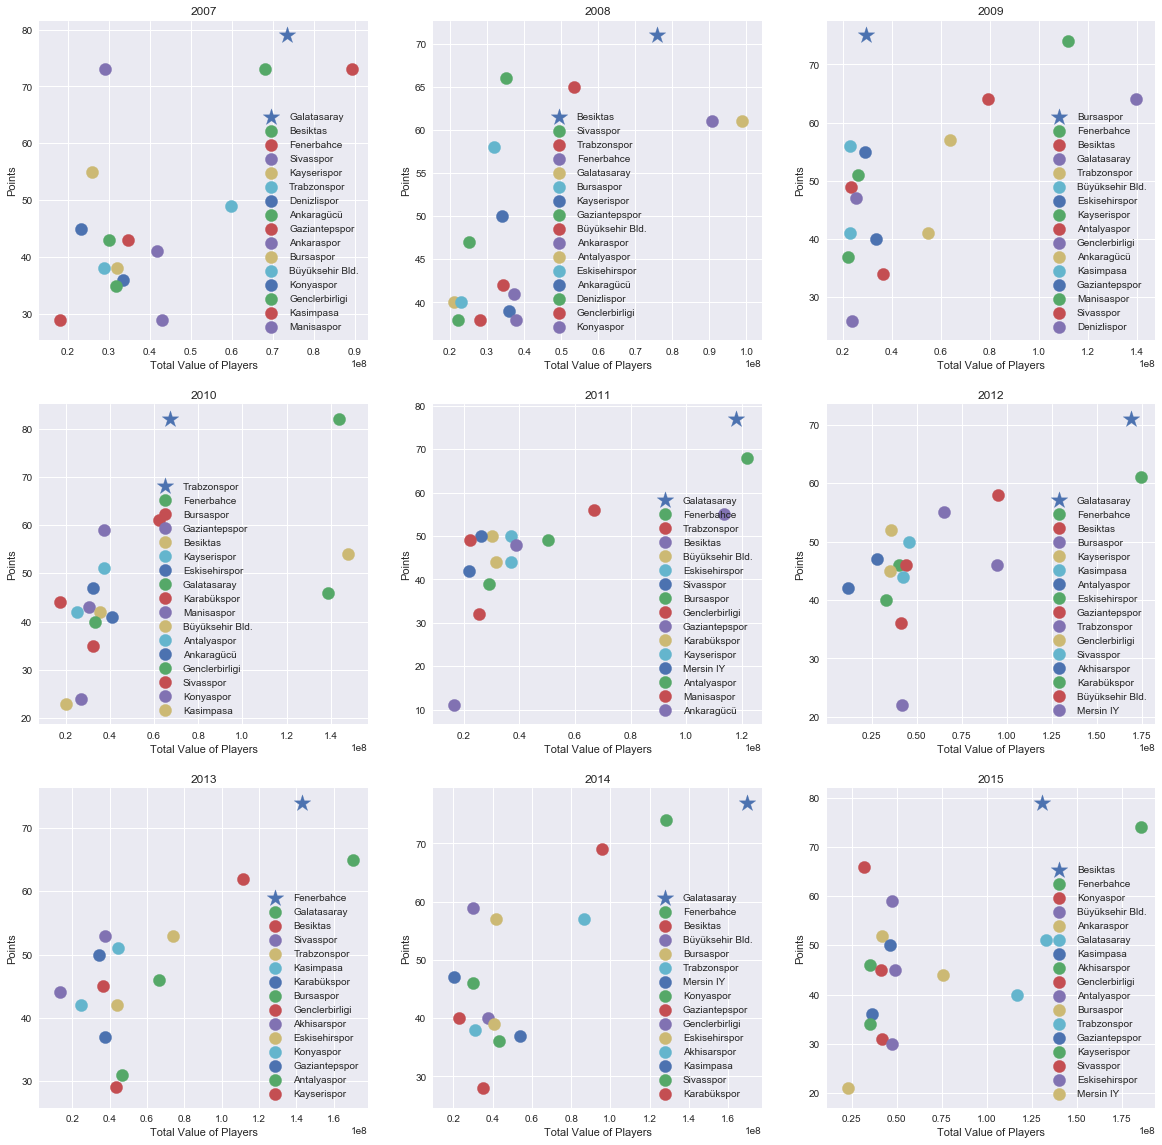

In [17]:
total_sum_per_season=players_df.groupby(["Season","Club"],as_index=False).agg({'Market Value' : np.sum})

p_df = pd.read_excel('train_data.xlsx', sheet_name='Points')
points_and_market_values=pd.merge(total_sum_per_season,p_df,on=["Season","Club"])
clubs_max3_points=p_df.loc[points_df.groupby(["Season"])["Points"].nlargest(10).index.levels[1]]
all_points_of_clubs_max3_points=pd.merge(clubs_max3_points,p_df,how="left",on=["Club"])
all_points_of_clubs_max3_points=all_points_of_clubs_max3_points.drop(columns=["Points_x","Season_x"]).drop_duplicates()
champions_points_values=pd.merge(total_sum_per_season,all_points_of_clubs_max3_points,left_on=["Season","Club"],right_on=["Season_y","Club"])
fig = plt.figure(figsize=(20,20))
for s in champions_points_values.Season.unique():
    ax1 = fig.add_subplot(int(str("33"+str(int(s-min(seasons)+1)))))
    ax1.set_ylabel("Points")
    ax1.set_xlabel("Total Value of Players")
    a=champions_points_values[champions_points_values["Season"]==s]
    a=a.sort_values("Points_y",ascending=False)
    ax1.scatter(a.iloc[0]["Market Value"], a.iloc[0]["Points_y"],label=a.iloc[0].Club,marker="*",s=300)
    for c in a.Club[1:]:
        ax1.scatter(a[a.Club==c]["Market Value"], a[a.Club==c]["Points_y"],label=c,s=150)
    ax1.set_title(s)
    plt.legend()
plt.show()


## Concat Final Model

In [18]:
feature_df.head()

Market Value        Age   Foreign  Multinational  \
Season Club                                                                
2007   Ankaragücü       9.701613e+05  25.258065  0.419355       0.225806   
       Ankaraspor       1.436207e+06  24.862069  0.517241       0.379310   
       Besiktas         2.344655e+06  24.068966  0.448276       0.275862   
       Bursaspor        9.397059e+05  24.352941  0.411765       0.147059   
       Büyüksehir Bld.  9.965517e+05  25.896552  0.206897       0.034483   

                        Value Ranking  Points  Ranking   age_std  multi_sum  \
Season Club                                                                   
2007   Ankaragücü                13.0    43.0      8.0  4.545824          7   
       Ankaraspor                 5.0    41.0     10.0  3.739023         11   
       Besiktas                   3.0    73.0      3.0  4.970851          8   
       Bursaspor                 14.0    38.0     13.0  4.169749          5   
       Büyüksehir Bld.           12.0    38.0     12.0  4.768534          1   

                        foreign_sum       ...         market_mean_cbrt  \
Season Club                               ...                            
2007   Ankaragücü                13       ...                98.995316   
       Ankaraspor                15       ...               112.825085   
       Besiktas                  13       ...               132.849419   
       Bursaspor                 14       ...                97.948393   
       Büyüksehir Bld.            6       ...                99.884925   

                          market_std  local_market_mean  foreign_market_mean  \
Season Club                                                                    
2007   Ankaragücü       8.178330e+05       7.083333e+05         1.332692e+06   
       Ankaraspor       1.149293e+06       1.507143e+06         1.370000e+06   
       Besiktas         1.785974e+06       2.082812e+06         2.666923e+06   
       Bursaspor        7.595632e+05       8.475000e+05         1.071429e+06   
       Büyüksehir Bld.  1.155262e+06       9.673913e+05         1.108333e+06   

                        local_age_mean  foreign_age_mean  market_norm  \
Season Club                                                             
2007   Ankaragücü            24.055556         26.923077     0.716837   
       Ankaraspor            25.285714         24.466667     1.061191   
       Besiktas              23.125000         25.230769     1.732429   
       Bursaspor             23.300000         25.857143     0.694334   
       Büyüksehir Bld.       25.521739         27.333333     0.736337   

                        age_norm  market_sum_cat  market_norm_cat  
Season Club                                                        
2007   Ankaragücü       1.015320           2g_4g          under_1  
       Ankaraspor       0.999402           4g_6g           over_1  
       Besiktas         0.967521         over_6g           over_1  
       Bursaspor        0.978936           2g_4g          under_1  
       Büyüksehir Bld.  1.040986           2g_4g          under_1  

[5 rows x 27 columns]

### One More Correlation Analysis To Go
Let's check how our engineered features relate to gathering points one last time. It seems like market_norm parameter is the headliner. And since market_xyz kind of features are highly correlated to it, they won't make it (they're basically representing the same relations possibly in a less efficient way). Then, foreign_age_mean, age_norm

In [19]:
corr = feature_df.corr()['Points']
# convert series to dataframe so it can be sorted
corr_df = pd.DataFrame(corr)
# correct column label from Points to correlation
corr_df.columns = ["Correlation"]
# sort correlation
corr_sorted = corr_df.sort_values(by=['Correlation'], ascending=False)
corr_sorted.head(40)

,Correlation
Points,1.000000
market_norm,0.733703
market_mean_cbrt,0.722545
market_mean_sqrt,0.719851
Market Value,0.700236
local_market_mean,0.682339
foreign_market_mean,0.677624
market_sum_sqrt,0.635375
market_sum_cbrt,0.635327
market_std,0.633554


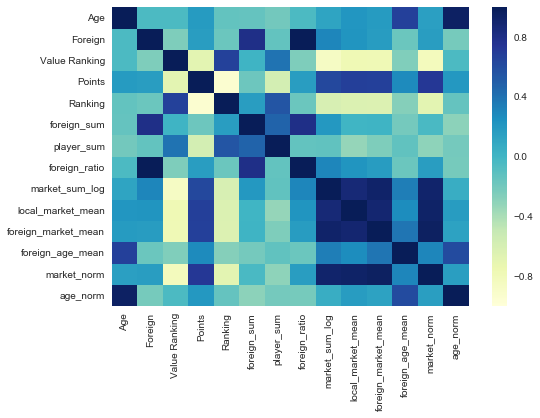

In [20]:
aa = feature_df.drop(['market_sum', 'Market Value', 'market_mean_cbrt', 'market_sum_cbrt','market_sum_sqrt',\
                       'market_mean_sqrt','market_std','multi_sum','age_std','local_age_mean','Multinational'], axis=1)
corr = aa.corr()
sns.heatmap(corr,cmap="YlGnBu")
plt.show()

In [21]:
def convert_points_to_predictions(predictions, shouldAscend):
    predictions['Real Rank'] = predictions['Real'].rank(ascending=shouldAscend,method='first')
    predictions['Predicted Rank'] = predictions['Predict'].rank(ascending=shouldAscend,method='first')
    return predictions

## Regression by Points

In [22]:
def run_over_seasons(final_df):
    tau_ = 0
    for season in range(2007,2015):
        train = final_df[final_df['Season']!=season]
        test = final_df[final_df['Season']==season]
        X_train = train.drop(['Points','Season'],axis=1)
        y_train = train['Points'].transform(lambda x: (x - x.mean()) / x.std())
        X_test = test.drop(['Points','Season'],axis=1)
        y_test = test['Points'].transform(lambda x: (x - x.mean()) / x.std())
        #X_train, X_test, y_train , y_test = train_test_split(final_df.drop('Points',axis=1),final_df['Points'],
         #                                                    test_size=0.1, random_state=1)
        # This is the regression model you will use
        final_model = LinearRegression(fit_intercept=False)
        final_model.fit(X_train,y_train)
        score = cross_val_score(final_model,X_train, y_train,cv=10)
        print(score)
        X_test.head()
        y_predict = final_model.predict(X_test)
        #a = mean_squared_error(y_test,y_predict)
        preds = pd.DataFrame({"Predict":y_predict})
        preds['Real']= y_test.reset_index().iloc[:,-1]
        ranks = pd.DataFrame()
        ranks['Real Rank'] = preds['Real'].rank(ascending=False,method='first')
        ranks['Predicted Rank'] = preds['Predict'].rank(ascending=False,method='first')
        #ranks = convert_points_to_predictions(preds,False)
        # ranks.head()
        # show ranks
        # print(ranks.sort_values(by='Real Rank',ascending=True))
        tau, _ = kendalltau(ranks['Predicted Rank'], ranks['Real Rank'])
        tau_ += tau
    print(tau_/9)
# Print tau both to file and screen
feature_df.dropna(inplace=True)
feature_no_index_3 = feature_df.reset_index()
feature_no_index_3['market_val_over'] = np.where(feature_no_index_3['Market Value'] >= 0.6e8, \
                                                 feature_no_index_3['Market Value'], 0)
feature_no_index_3['market_val_under'] = np.where(feature_no_index_3['Market Value'] < 0.6e8, \
                                                 feature_no_index_3['Market Value'], 0)
final_df = feature_no_index_3[['Season','foreign_sum','foreign_age_mean','player_sum','market_norm','Points']].copy()
# final_df['local_valuable_param'] = final_df.market_mean *(1-final_df.foreign_ratio)
# one hot encoding
# one_hot = pd.get_dummies(feature_no_index_3['Club'],drop_first=True)
# final_df = final_df.join(one_hot)

## very small difference
one_hot = pd.get_dummies(feature_no_index_3['market_sum_cat'],drop_first=True)
final_df = final_df.join(one_hot)
run_over_seasons(final_df)

[ 0.73218269  0.50499407  0.72946466  0.66826623  0.72750669  0.63662558
  0.6664929   0.77254532  0.4737794   0.47269075]
[ 0.75913465  0.40311049  0.72259902  0.70043363  0.70481298  0.64458532
  0.68521183  0.78194096  0.49034185  0.44779767]
[ 0.76215384  0.57635397  0.84158361  0.66704935  0.69906331  0.64175883
  0.6956126   0.78458147  0.4806409   0.4595396 ]
[ 0.73955525  0.58568805  0.5517714   0.69761857  0.7254346   0.63841632
  0.72430312  0.77546012  0.47277095  0.46388868]
[ 0.7671563   0.58216981  0.54141495  0.74750218  0.68717934  0.6438241
  0.68732939  0.7834281   0.48861273  0.44021124]
[ 0.75638403  0.58574966  0.55330353  0.75006107  0.72085072  0.70873644
  0.71440487  0.78357783  0.48929725  0.43785913]
[ 0.72914349  0.5867305   0.55739163  0.75521998  0.74703198  0.71173987
  0.47584714  0.75225671  0.48332868  0.43668074]
[ 0.73752884  0.59641876  0.57448338  0.73269682  0.72592892  0.714337
  0.4790709   0.65470499  0.54508116  0.44691171]
0.557007988381


## Regression by Ranking

In [23]:
corr = feature_df.corr()['Ranking']
# convert series to dataframe so it can be sorted
corr_df = pd.DataFrame(corr)
# correct column label from Points to correlation
corr_df.columns = ["Correlation"]
# sort correlation
corr_sorted = corr_df.sort_values(by=['Correlation'], ascending=False)
corr_sorted.head(15)

,Correlation
Ranking,1.000000
Value Ranking,0.665473
player_sum,0.547420
foreign_sum,0.164948
multi_sum,0.026771
local_age_mean,0.010942
age_std,-0.022735
Age,-0.134237
age_norm,-0.140768
Multinational,-0.151017


In [24]:
season = 2014  # to predict the ranking of 2015
feature_df.dropna(inplace=True)
feature_no_index_2 = feature_df.reset_index()
final_df = feature_no_index_2[['Season','Age','foreign_sum','player_sum','market_std','Market Value','Ranking']]
train = final_df[final_df['Season']!=season]
test = final_df[final_df['Season']==season]
X_train = train.drop(['Ranking','Season'],axis=1)
y_train = train['Ranking']
X_test = test.drop(['Ranking','Season'],axis=1)
y_test = test['Ranking']

# This is the regression model you will use
final_model_rank = LinearRegression(fit_intercept=False)
final_model_rank.fit(X_train,y_train)
score = cross_val_score(final_model_rank,X_train, y_train,cv=10)
# print(score)
y_predict = final_model_rank.predict(X_test)
#a = mean_squared_error(y_test,y_predict)
preds_rank = pd.DataFrame({"Predict":y_predict})
preds_rank['Real']= y_test.reset_index().iloc[:,-1]
# ranks.head()
# show ranks
print(preds_rank.sort_values(by='Real',ascending=True))
tau, _ = kendalltau(preds_rank['Predict'], preds_rank['Real'])
# Print tau both to file and screen
print(tau)

      Predict  Real
7   -2.153907   1.0
6   -1.640406   2.0
2    3.269214   3.0
4    8.417390   4.0
17   8.865516   5.0
3    6.113740   6.0
14   9.752227   7.0
13   9.037056   8.0
9   11.133426   9.0
8   12.225391  10.0
5   11.480447  11.0
0   12.059354  12.0
12   9.458880  13.0
15   8.961396  14.0
16   8.366032  15.0
11  10.412785  16.0
10  12.304317  17.0
1   11.010835  18.0
0.529411764706


## Further analysis with R-squared and Adjusted R-squared scoring
R-squared scoring shows how good is the current potential trendline compared to the known average that anybody can think of. It is a measure of goodness of fit (greater is better).

However, there is a major issue with using only R-squared since it is biased and will _never_ decrease. When a new feature is added to the model, the regressor would find a way to fit it. In the worst case, its coefficient would be 0. This means that R-squared will definitely increase (or unchanged), which makes you think this new feature made the model better. Here, using adjusted R-squared score is a better idea. It panalizes the regressor for adding independent variable that actually doesn't help to make the model better.

In [25]:
feature_df.dropna(inplace=True)
feature_no_index_3 = feature_df.reset_index()
feature_no_index_3['market_val_over'] = np.where(feature_no_index_3['Market Value'] >= 0.6e8, \
                                                 feature_no_index_3['Market Value'], 0)
feature_no_index_3['market_val_under'] = np.where(feature_no_index_3['Market Value'] < 0.6e8, \
                                                 feature_no_index_3['Market Value'], 0)
final_df = feature_no_index_3[['Season','foreign_sum','foreign_age_mean','player_sum','market_norm','Points']].copy()
one_hot = pd.get_dummies(feature_no_index_3['market_sum_cat'],drop_first=True)
final_df = final_df.join(one_hot)

X = final_df.drop(['Points','Season'],axis=1)
y = final_df['Points']
y2 = final_df['Points'].transform(lambda x: (x - x.mean()) / x.std())
y3 = final_df['Points'].transform(lambda x: (x - x.mean()) / (x.max() - x.min()))

import statsmodels.formula.api as sm
def backwardEliminationWithAdjustedRSquared(x, y, SL):
    numVars = len(x[0])
    temp = np.zeros((len(x),numVars)).astype(int)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print ('-', regressor_OLS.summary())
                        return x_rollback, regressor_OLS
                    else:
                        continue
    print(regressor_OLS.summary())
    return x

def backwardElimination(x, y, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    print (regressor_OLS.summary())
    return x
 
SL = 0.05
X_opt = np.array(X).reshape(-1, X.shape[1])
for y_opt in [y, y2, y3]:
    X_Modeled = backwardElimination(X_opt, y_opt, SL)
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_Modeled, y_opt)
    taus = []
    start = 0
    for season in range(2007,2015):
        club_count = points_df[points_df['Season'] == season].shape[0]
        y_predict = final_model.predict(X_Modeled[start:start+club_count])
        preds = pd.DataFrame({"Predict":y_predict})
        preds['Real'] = y_opt[start:start+club_count].reset_index().iloc[:,-1]
        
        ranks = pd.DataFrame()
        ranks['Real Rank'] = preds['Real'].rank(ascending=False,method='first')
        ranks['Predicted Rank'] = preds['Predict'].rank(ascending=False,method='first')
        tau, _ = kendalltau(ranks['Predicted Rank'], ranks['Real Rank'])
        
        taus.append(tau)
        start += club_count

    print('Mean of taus:', str(np.mean(taus)) + '\n\n')

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1707.
Date:                Thu, 12 Apr 2018   Prob (F-statistic):          3.99e-120
Time:                        19:15:58   Log-Likelihood:                -572.68
No. Observations:                 161   AIC:                             1151.
Df Residuals:                     158   BIC:                             1161.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5297      0.192     13.155      0.0

### Results
As the results show, predicting the points instead of direct ranking is better in terms of Kendall Tau scoring. Until getting these results, too many different feature sets with different approaches (normalizations, standardizations etc.) and scoring schemas (R-square scoring, adjusted R-square scoring etc.) have been tried.

Standardization/normalization made the results __better__. Another thing that R-squared showed is 'Foreign sum' feature does not make it any better. The best feature set that is going to be used below for the test evaluation contains the following features:

<br><br><br><br>

# The code in the given base notebook
Below, the base notebook content has been used without any major changes. The changes made are as follows:
* The empty functions (construct_features and construct_labels) are filled according to the feature set described above. 
* Since we're predicting points, not the rankings, convert_points_to_predictions function is implemented to convert the predicted features points into rankings.
* y_test is also given to convert_points_to_predictions function to convert the points to the rankings.
* In one season (2009), one of the Clubs (Ankaraspor) is disqualified from the league, so that it does not have any point information in the season. Therefore, its features should be removed from the dataset as well. A line of code is inserted to remove such cases from X_train and X_test.

In [26]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from scipy.stats import kendalltau

# Evaluation

In [27]:
# Fill this function to construct a data frame X that contains your final features extracted from the dataset
def construct_features(df):
    players_group_sc = df.set_index(['Season','Club']).sort_index()
    whole_df = pd.DataFrame(players_group_sc)
    data_means = df.groupby(['Season', 'Club']).mean()[['Market Value', 'Age','Foreign','Multinational']]
    all_players = df.groupby(['Season', 'Club']).count()[['Player']]
    data_sums = df.groupby(['Season', 'Club']).sum()[['Market Value', 'Age','Foreign','Multinational']]
    club_nation_stats = df.groupby(['Season', 'Club','Foreign']).mean()[['Market Value','Age']]
    data_stds = df.groupby(['Season', 'Club']).std()[['Market Value', 'Age']]    
    feature_df = pd.DataFrame(data_means)
    feature_df['Value Ranking'] = data_means.groupby('Season')['Market Value'].rank(ascending=False,method='first')
    feature_df['age_std'] = data_stds['Age'].copy()
    feature_df['multi_sum'] = data_sums['Multinational'].copy()
    feature_df['foreign_sum'] = data_sums['Foreign'].copy()
    feature_df['player_sum'] = all_players['Player'].copy()
    feature_df['foreign_ratio'] = (feature_df['foreign_sum'] / feature_df['player_sum']).copy()
    feature_df['market_sum'] = data_sums['Market Value'].copy()
    feature_df['market_sum_log'] = np.log(data_sums['Market Value']).copy()
    feature_df['market_sum_sqrt'] = np.sqrt(data_sums['Market Value']).copy()
    feature_df['market_sum_cbrt'] = np.cbrt(data_sums['Market Value']).copy()
    feature_df['market_mean_sqrt'] = np.sqrt(data_means['Market Value']).copy()
    feature_df['market_mean_cbrt'] = np.cbrt(data_means['Market Value']).copy()
    feature_df['market_std'] = data_stds['Market Value'].copy()
    club_nation_stats = club_nation_stats.reset_index().set_index(['Season', 'Club'])
    feature_df['local_market_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==0,'Market Value']
    feature_df['foreign_market_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==1,'Market Value']
    feature_df['local_age_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==0,'Age']
    feature_df['foreign_age_mean']=club_nation_stats.loc[club_nation_stats['Foreign']==1,'Age']
    means = data_means.reset_index()
    means_normalized_by_season = means.groupby(['Season']).transform(lambda x: x/x.mean())
    means_normalized_by_season.head()
    feature_df.reset_index(inplace=True)
    feature_df['market_norm'] = means_normalized_by_season['Market Value']
    feature_df['age_norm'] = means_normalized_by_season['Age']
    feature_df = feature_df.set_index(['Season', 'Club'])
    feature_df.loc[feature_df['market_sum'] > 0.6e8, 'market_sum_cat'] = 'over_6g'
    feature_df.loc[feature_df['market_sum'] < 0.6e8, 'market_sum_cat'] = '4g_6g'
    feature_df.loc[feature_df['market_sum'] < 0.4e8, 'market_sum_cat'] = '2g_4g'
    feature_df.loc[feature_df['market_sum'] < 0.2e8, 'market_sum_cat'] = 'under_2g'
    feature_df.loc[feature_df['market_norm'] >= 1, 'market_norm_cat'] = 'over_1'
    feature_df.loc[feature_df['market_norm'] < 1, 'market_norm_cat'] = 'under_1'

    feature_no_index_3 = feature_df.reset_index()
    feature_no_index_3['market_val_over'] = np.where(feature_no_index_3['Market Value'] >= 0.6e8, \
                                                 feature_no_index_3['Market Value'], 0)
    feature_no_index_3['market_val_under'] = np.where(feature_no_index_3['Market Value'] < 0.6e8, \
                                                 feature_no_index_3['Market Value'], 0)
    final_df = feature_no_index_3[['Season','Club','foreign_age_mean','player_sum','market_norm']].copy()
    one_hot = pd.get_dummies(feature_no_index_3['market_sum_cat'],drop_first=True)
#     final_df = final_df.join(one_hot)
    final_df = final_df.set_index(['Season','Club']).sort_index()

    return final_df

In [28]:
# Fill this function to construct a data frame y that contains the labels of the test data
def construct_labels(df):
    points_group_sc = df.set_index(['Season','Club']).sort_index()
    points_group_sc.dropna(inplace=True)
    points_group_sc['Points'] = points_group_sc['Points'].transform(lambda x: (x - x.mean()) / x.std())
    return points_group_sc.Points

In [29]:
# If you try to choose to predict points instead of rankings then you should implement this function as well
# to generate rankings. If you predict the rankings directly, you can leave this function as it is.
def convert_points_to_predictions(predictions):
    predictions = pd.DataFrame(predictions)
    return predictions.rank(method='first')

In [30]:
# This function will evaluate your features test performance using the ranking predictions
def compute_test_score(outfile_name):
    # X_test should contain the feature you engineered and y_test should contain the corresponding labels, which are team rankings 
    X_train = construct_features(pd.read_excel('train_data.xlsx',sheet_name='Player'))
    y_train = construct_labels(pd.read_excel('train_data.xlsx',sheet_name='Points'))
    X_train = X_train[X_train.index.isin(y_train.index)] # to remove any Club disqualified from the league
    
    X_test = construct_features(pd.read_excel('../../test_data.xlsx',sheet_name='Player'))
    y_test = construct_labels(pd.read_excel('../../test_data.xlsx',sheet_name='Points'))
    X_test = X_test[X_test.index.isin(y_test.index)] # to remove any Club disqualified from the league
    
    # This is the regression model you will use
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train,y_train)
    # Your model's predictions will be stored in this array
    predictions = final_model.predict(X_test)
    # Your model can predict either points or rankings. If necessary, change the function above
    predictions = convert_points_to_predictions(predictions)
    y_test = convert_points_to_predictions(y_test)
    # Your performance on the test set
    tau, _ = kendalltau(predictions, y_test)
    # Print tau both to file and screen
    print(tau)
    f = open(outfile_name, 'w')
    f.write(str(tau))
    f.close()

#outfile name should have the format ID1_ID2_ID3.txt
outfile_name = 'out.txt'
compute_test_score(outfile_name)

0.424836601307
